# Analysing W3 radio spectra obtained from OSO 20m telescope

In this notebook, we will analyse a spectrum of Onsala-1 molecular cloud obtained from 20m telescope at OSO. The spectra were measured in radio frequencies and have four emission lines of $CH_3CCH$. The main goal is to find the area under the lines, which is basically the integrated antenna temperature under these lines. With this we can compute the column density of the $CH_3CCH$.

The focus of this notebook is Onsala-1. Once we have worked it out, we can make a routine to compute the same for the rest of the targets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from glob import glob
import astropy.constants as con
import utils as utl
from scipy.optimize import minimize
import dynesty
from scipy import stats
import pickle
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal

We first make a list of all fits file which has spectrum of W3. We also list the system temperature and the total integration time, which we need to compute the combined/average spectrum (to gain a higher S/N).

In [2]:
# Listing all of the fits file
f1 = glob('/Users/japa6985/data/*.fits')
ons, tsys, int_time = np.array([]), np.array([]), np.array([])
print('File\t\tObject\t\tT_sys\tINTTIME')
print('-----------------------------------------------')
for i in range(len(f1)):
    hdul = fits.open(f1[i])
    hdr = hdul[0].header
    if hdr['OBJECT'] == 'W3(OH)':
        ons = np.hstack((ons, f1[i]))
        tsys, int_time = np.hstack((tsys, hdr['TSYS'])),\
             np.hstack((int_time, hdr['INTTIME']))
        print(f1[i].split('/')[-1] + '\t' + hdr['OBJECT'] + '\t'\
             + str(hdr['TSYS']) + '\t' + str(hdr['INTTIME']))

File		Object		T_sys	INTTIME
-----------------------------------------------
2135086a.fits	W3(OH)	176.27	202.387
2135182a.fits	W3(OH)	192.03	203.948
2135105a.fits	W3(OH)	180.94	203.157
2135138a.fits	W3(OH)	185.58	203.104
2135080a.fits	W3(OH)	176.27	203.129
2135160a.fits	W3(OH)	187.85	203.996
2135179a.fits	W3(OH)	192.03	203.072
2135146a.fits	W3(OH)	186.96	203.178
2135127a.fits	W3(OH)	183.61	203.972
2135141a.fits	W3(OH)	185.58	202.372
2135102a.fits	W3(OH)	180.94	203.123
2135163a.fits	W3(OH)	187.85	202.369
2135083a.fits	W3(OH)	176.27	202.401
2135124a.fits	W3(OH)	183.61	203.152
2135119a.fits	W3(OH)	180.64	203.926
2135185a.fits	W3(OH)	192.03	204.02
2135201a.fits	W3(OH)	197.7	202.363
2135149a.fits	W3(OH)	186.96	203.169
2135094a.fits	W3(OH)	178.02	202.403
2135174a.fits	W3(OH)	191.18	202.259
2135190a.fits	W3(OH)	195.2	204.001
2135152a.fits	W3(OH)	186.96	203.988
2135196a.fits	W3(OH)	195.2	203.903
2135113a.fits	W3(OH)	180.64	203.989
2135108a.fits	W3(OH)	180.94	203.981
2135135a.fits	W3(OH)	185.58	

We can now compute an average spectrum out of all of these spectra!

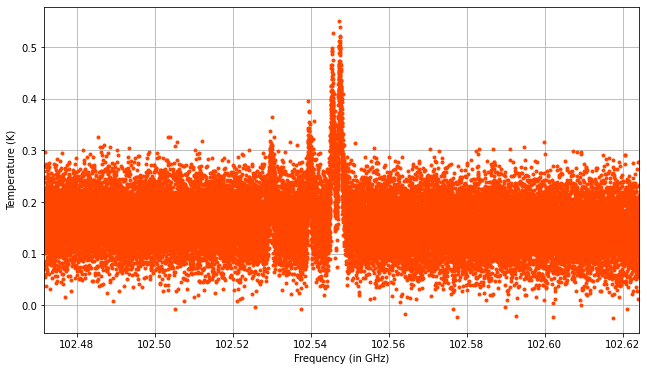

In [3]:
# For zeroth spectra
hdul5 = fits.open(ons[0])
hdr5, dta5 = hdul5[0].header, hdul5[0].data[0][0]
ii5 = np.arange(hdr5['NAXIS1']) + 1
freq_all = hdr5['RESTFREQ'] + hdr5['CRVAL1'] + hdr5['CDELT1']*(ii5-hdr5['CRPIX1'])
freq_all = int_time[0]*freq_all/tsys[0]
temp_all = int_time[0]*dta5/tsys[0]
# For all other spectra
for i in range(len(ons)-1):
    hdul5 = fits.open(ons[i+1])
    hdr5, dta5 = hdul5[0].header, hdul5[0].data[0][0]
    ii5 = np.arange(hdr5['NAXIS1']) + 1
    frq5 = hdr5['RESTFREQ'] + hdr5['CRVAL1'] + hdr5['CDELT1']*(ii5-hdr5['CRPIX1'])
    # Saving the data
    temp_all = np.vstack((temp_all, int_time[i+1]*dta5/tsys[i+1]))
    freq_all = np.vstack((freq_all, int_time[i+1]*frq5/tsys[i+1]))
# Weighted average (weighted with int_time/Tsys) over all the spectra
freq_avg = np.sum(freq_all, axis=0)/np.sum(int_time/tsys)
temp_avg = np.sum(temp_all, axis=0)/np.sum(int_time/tsys)

# Plotting the result:
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(freq_avg/1e9, temp_avg, fmt='.', c='orangered')
plt.xlabel('Frequency (in GHz)')
plt.ylabel('Temperature (K)')
plt.xlim([np.min(freq_avg/1e9), np.max(freq_avg/1e9)])
plt.grid()

There we go! This is a nice spectrum of Onsala 1!
We can first convert frequency to the velocity first -- to do this we can use the following Doppler formula:

$$v = c \cdot \frac{f_s - f_o}{f_s}$$

The symbols have their usual meanings.

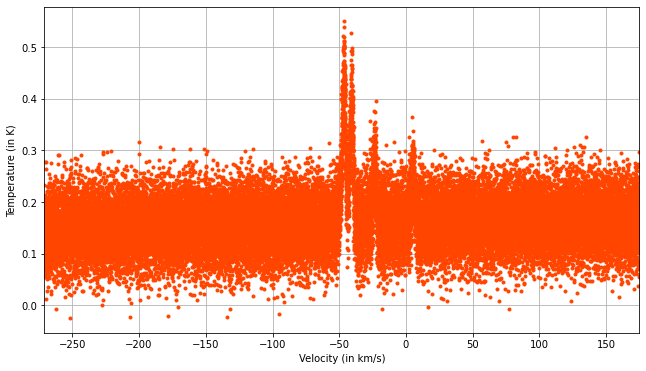

In [4]:
# To find the rest frame frequency
diff = freq_avg - hdr5['OBSFREQ']
rest_freq = hdr5['RESTFREQ']#freq_avg + diff
# To find the velocity of the target!
velo_avg = con.c.value*(rest_freq - freq_avg)/rest_freq
velo_avg = velo_avg + hdr5['VLSR']# + hdr5['VELO-GEO'] + hdr5['VELO-HEL']
# We can plot the results
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(velo_avg/1e3, temp_avg, fmt='.', c='orangered')
plt.xlabel('Velocity (in km/s)')
plt.ylabel('Temperature (in K)')
plt.xlim([np.min(velo_avg/1e3), np.max(velo_avg/1e3)])
plt.grid()

And this is how the zoomed in spectrum would look like...

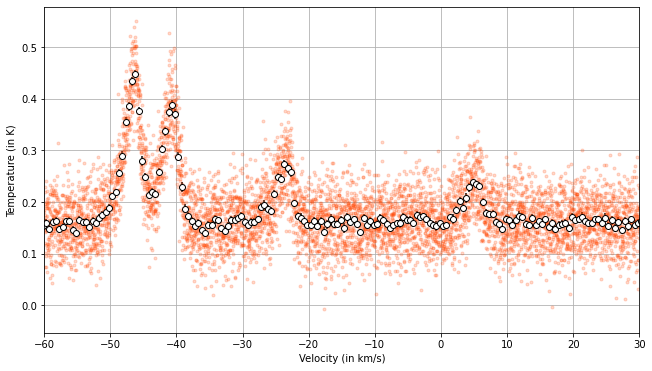

In [5]:
# We can plot the results
## Binned data
velo_bin, temp_bin, temp_err_bin, _ = utl.lcbin(velo_avg, temp_avg, binwidth=500)
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(velo_avg/1e3, temp_avg, fmt='.', c='orangered', alpha=0.2)
plt.errorbar(velo_bin/1e3, temp_bin, yerr=temp_err_bin, fmt='o', mfc='white', c='black')
plt.xlabel('Velocity (in km/s)')
plt.ylabel('Temperature (in K)')
plt.xlim([-60, 30])
plt.grid()

## And the fitting...

So, there are four lines (though we cannot see them individually) along with some offset trend. What we can do is to build a model that has four gaussian models and a linear model. Then we can use `dynesty` to fit the model.

In [6]:
def model(x, m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4):
    ln1 = utl.line(x, m, c)
    gau1 = utl.gaus(x, am1, mu1, si1)
    gau2 = utl.gaus(x, am2, mu2, si2)
    gau3 = utl.gaus(x, am3, mu3, si3)
    gau4 = utl.gaus(x, am4, mu4, si4)
    return ln1 + gau1 + gau2 + gau3 + gau4

def chi_sqrd(x):
    #global velo_avg, temp_avg, temp_err
    m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4 = x
    mod = model(velo_avg, m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4)
    chi2 = (temp_avg - mod)**2
    return 0.5*np.sum(chi2)/2

def log_like_chi(x):
    m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4 = x
    mod = model(velo_avg, m, c, am1, am2, am3, am4, mu1, mu2, mu3, mu4, si1, si2, si3, si4)
    resid = temp_avg-mod
    chi2 = np.sum(-resid**2)
    return chi2/2

We can now use `scipy.optimize.minimize` to find the "first" best-fitted parameters.

(14, 14)


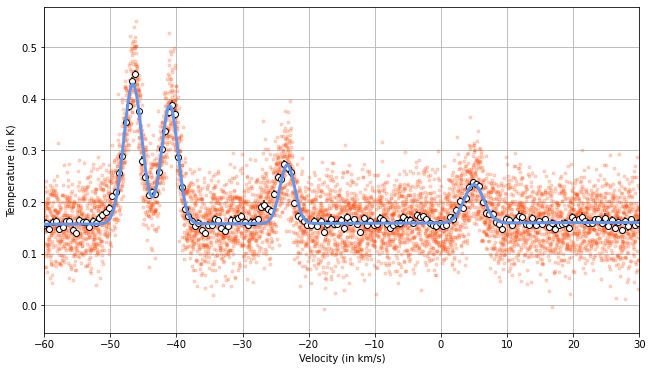

In [7]:
xinit = np.array([0., 0.15, 0.4, 0.3, 0.15, 0.1,\
     -47000, -41000, -23000, 5000, 1.5*1000, 1.5*1000, 1.5*700, 1.5*1000])
soln = minimize(chi_sqrd, x0=xinit, method='BFGS')

hess = soln.hess_inv
print(hess.shape)

vall = np.linspace(np.min(velo_avg), np.max(velo_avg), 10000)
best_fit = model(vall, *soln.x)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(velo_avg/1e3, temp_avg, fmt='.', c='orangered', alpha=0.2)
plt.errorbar(velo_bin/1e3, temp_bin, yerr=temp_err_bin, fmt='o', mfc='white', c='black')
plt.plot(vall/1e3, best_fit, c='cornflowerblue', lw=3, zorder=5)
plt.xlabel('Velocity (in km/s)')
plt.ylabel('Temperature (in K)')
plt.xlim([-60, 30])
plt.grid()

In [8]:
# Printing the results:
solnx, solnx_err = np.zeros(len(soln.x)), np.zeros(len(soln.x))
print('Chi2: ', soln.fun)
for i in range(len(soln.x)):
    solnx[i], solnx_err[i] = soln.x[i], np.sqrt(soln.hess_inv[i][i])
    print('x' + str(i) + ': ' + str(soln.x[i]) + ' +/- ' + str(np.sqrt(soln.hess_inv[i][i])))

Chi2:  16.5241710083697
x0: 3.8014200575448975e-08 +/- 6.141477057332781e-08
x1: 0.159524539545196 +/- 0.008553650348343673
x2: 0.2704478618613994 +/- 0.14374891637860046
x3: 0.2284889070334494 +/- 0.14998822568379142
x4: 0.11316855126147414 +/- 0.12311606456314107
x5: 0.0742233184026735 +/- 0.10319862120254675
x6: -46588.28124829908 +/- 0.19010075801859025
x7: -41017.99556353672 +/- 2.0974781534381157
x8: -23244.649831679937 +/- 1.42292369623139
x9: 4980.058339687436 +/- 1.0487199059423087
x10: 1374.0280399071157 +/- 1.4388768445850928
x11: 1249.2710554068397 +/- 2.4783432194866997
x12: 1130.982322290887 +/- 1.298245898270024
x13: 1492.217896135569 +/- 1.0002027916448049


Using `dynesty` to perform a more robust analysis!

In [9]:
def uniform(t, a, b):
    return (b-a)*t + a
def stand(a, loc, scale):
    return (a-loc)/scale

def prior_transform(ux):
    x = np.array(ux)
    # Linear function:
    x[0], x[1] = stats.norm.ppf(ux[0], loc=solnx[0], scale=solnx_err[0]),\
        stats.norm.ppf(ux[1], loc=solnx[1], scale=solnx_err[1])
    # Amplitudes:
    x[2], x[3], x[4], x[5] = stats.truncnorm.ppf(ux[2], stand(0, solnx[2], solnx_err[2]), stand(0.55, solnx[2], solnx_err[2]), loc=solnx[2], scale=solnx_err[2]),\
        stats.truncnorm.ppf(ux[3], stand(0, solnx[3], solnx_err[3]), stand(0.5, solnx[3], solnx_err[3]), loc=solnx[3], scale=solnx_err[3]),\
        stats.truncnorm.ppf(ux[4], stand(0, solnx[4], solnx_err[4]), stand(0.35, solnx[4], solnx_err[4]), loc=solnx[4], scale=solnx_err[4]),\
        stats.truncnorm.ppf(ux[5], stand(0, solnx[5], solnx_err[5]), stand(0.3, solnx[5], solnx_err[5]), loc=solnx[5], scale=solnx_err[5])
    # Central positions:
    x[6], x[7], x[8], x[9] = stats.norm.ppf(ux[6], loc=solnx[6], scale=solnx_err[6]), stats.norm.ppf(ux[7], loc=solnx[7], scale=solnx_err[7]),\
         stats.norm.ppf(ux[8], loc=solnx[8], scale=solnx_err[8]), stats.norm.ppf(ux[9], loc=solnx[9], scale=solnx_err[9])
    # Widths:
    x[10], x[11], x[12], x[13] = stats.norm.ppf(ux[10], loc=solnx[10], scale=solnx_err[10]), stats.norm.ppf(ux[11], loc=solnx[11], scale=solnx_err[11]),\
         stats.norm.ppf(ux[12], loc=solnx[12], scale=solnx_err[12]), stats.norm.ppf(ux[13], loc=solnx[13], scale=solnx_err[13])
    return x

In [10]:
dsampler = dynesty.DynamicNestedSampler(loglikelihood=log_like_chi, prior_transform=prior_transform,\
    ndim=14, nlive=500, bound='multi', sample='rwalk')
dsampler.run_nested()
dres = dsampler.results

13540it [05:49, 38.71it/s, batch: 7 | bound: 0 | nc: 1 | ncall: 343677 | eff(%):  3.940 | loglstar:   -inf < -33.239 < -34.775 | logz: -36.272 +/-  0.037 | stop:  0.887]         


In [11]:
print('Keys: ', dres.keys())
dres.summary()

Keys:  ['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'batch_nlive', 'batch_bounds', 'logzerr', 'information', 'bound', 'bound_iter', 'samples_bound', 'scale']
Summary
niter: 13540
ncall: 343677
eff(%):  3.940
logz: -36.276 +/-  0.036


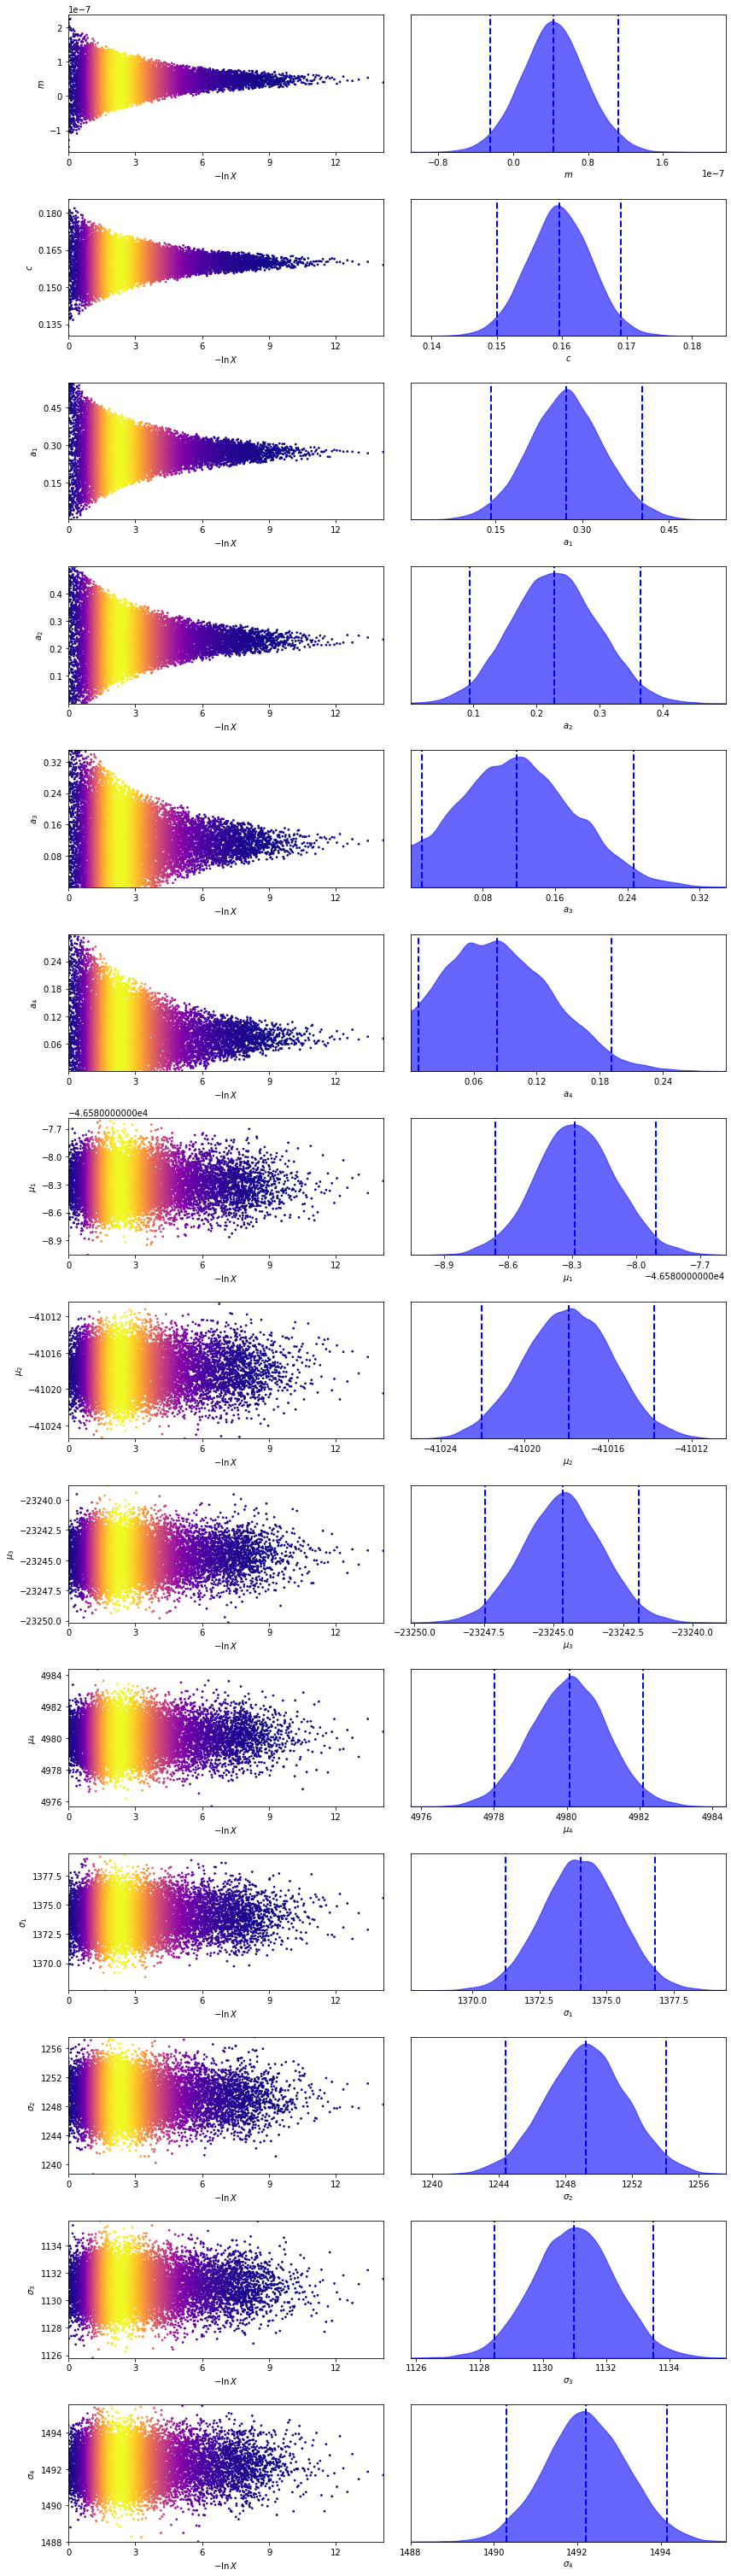

In [12]:
labels = [r'$m$', r'$c$', r'$a_1$', r'$a_2$', r'$a_3$', r'$a_4$',\
    r'$\mu_1$', r'$\mu_2$', r'$\mu_3$', r'$\mu_4$',\
    r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$', r'$\sigma_4$']

fig, axes = dyplot.traceplot(dres, labels=labels)
fig.tight_layout()


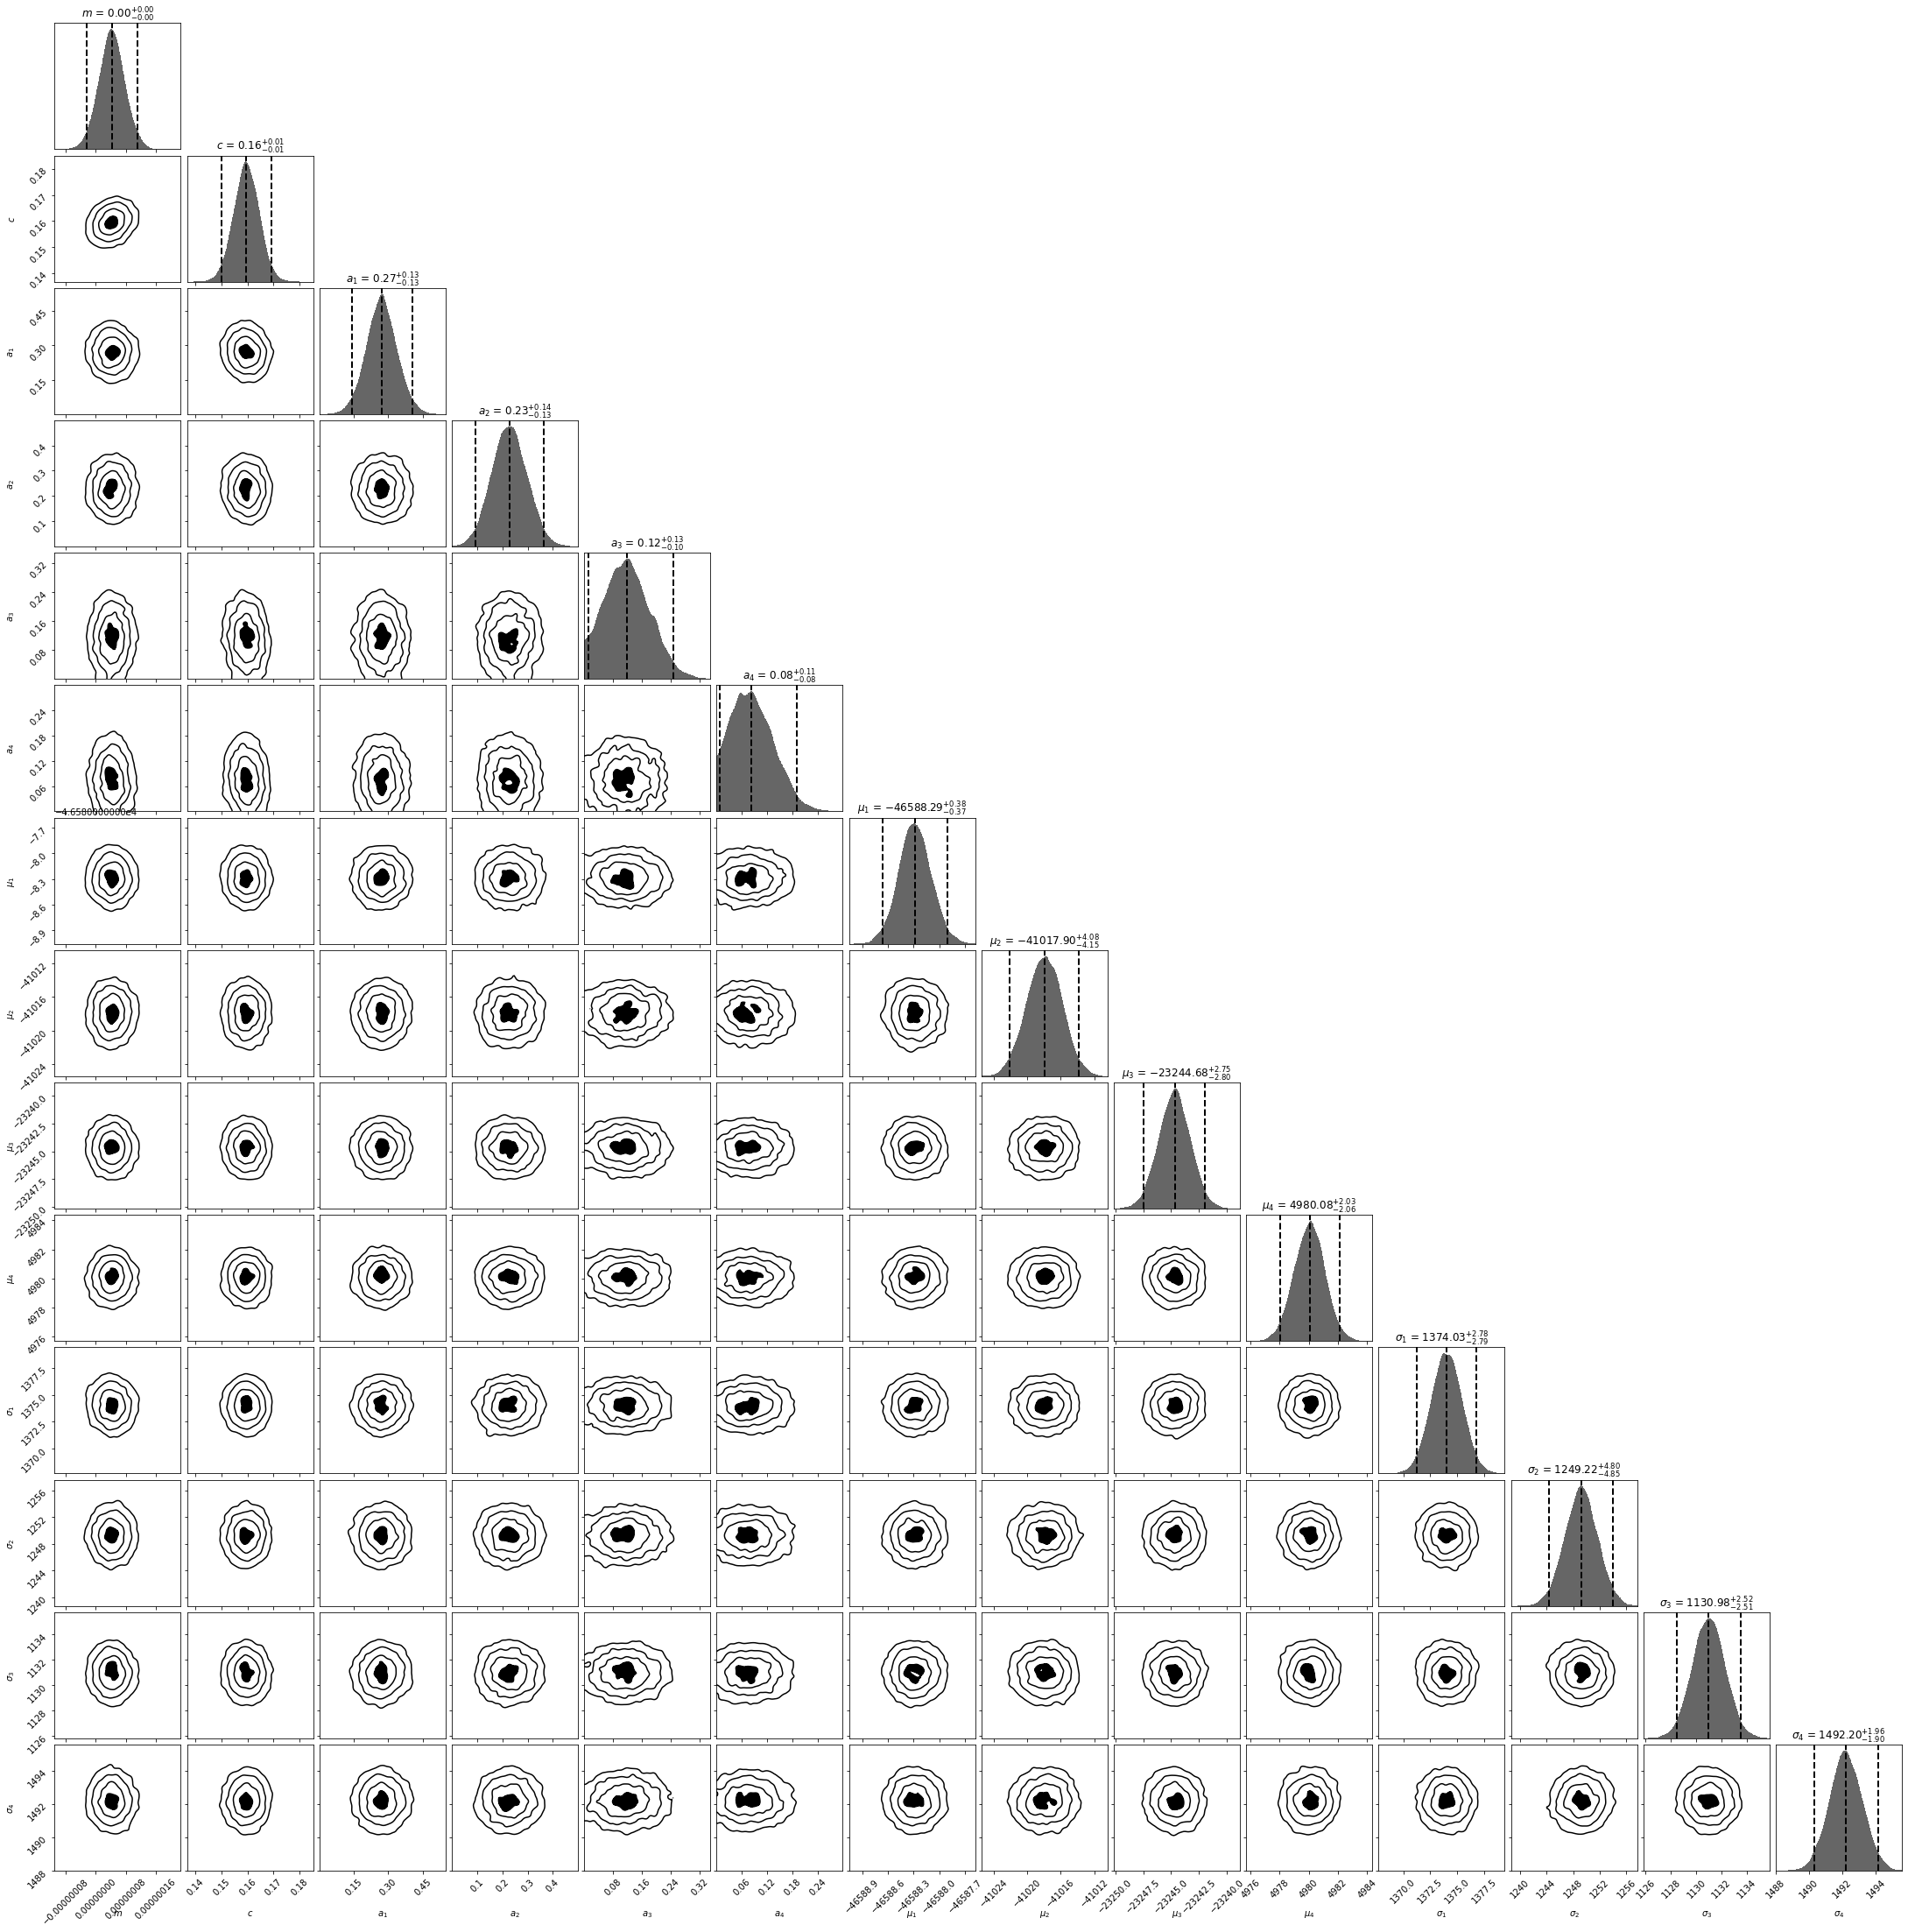

In [13]:
fig, axes = dyplot.cornerplot(dres, show_titles=True, labels=labels)

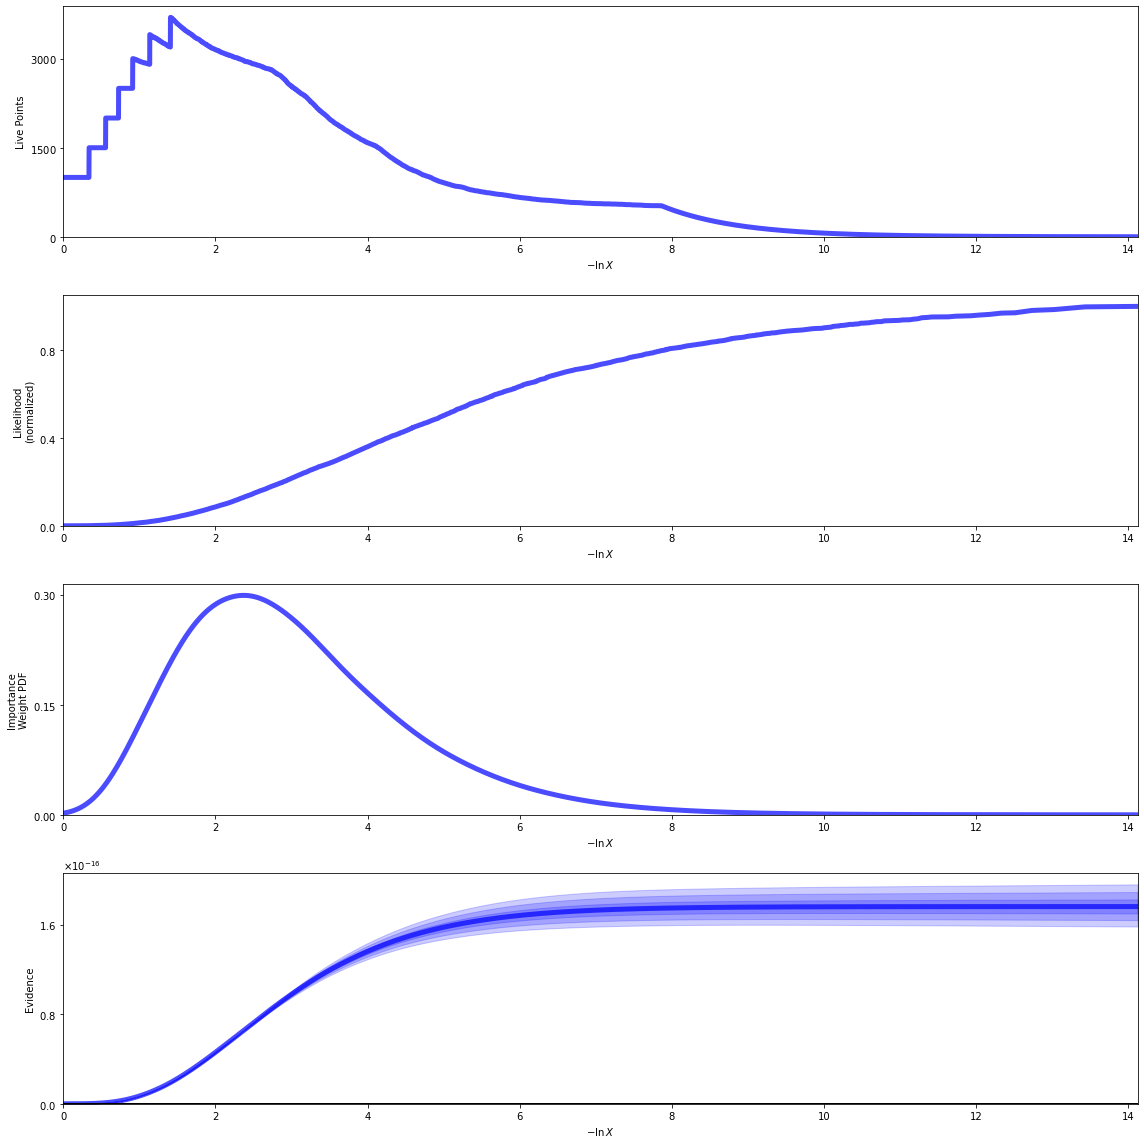

In [14]:
# analytic evidence solution
lnz_truth = len(temp_avg) * -np.log(2 * 10.)  # log(volume) of prior; log(like) is normalized
fig, axes = dyplot.runplot(dres, color='blue', lnz_truth=lnz_truth, truth_color='black')
fig.tight_layout()

In [15]:
weights = np.exp(dres['logwt'] - dres['logz'][-1])
posterior_samples = resample_equal(dres.samples, weights)

In [16]:
labels1 = ['m', 'c', 'a_1', 'a_2', 'a_3', 'a_4',\
    'mu_1', 'mu_2', 'mu_3', 'mu_4', 'sigma_1', 'sigma_2', 'sigma_3', 'sigma_4']

post_samps = {}
post_samps['samples'] = {}
for i in range(len(labels1)):
    post_samps['samples'][labels1[i]] = posterior_samples[:, i]

# logZ
post_samps['lnZ'] = dres.logz
post_samps['lnZ_err'] = dres.logzerr

# Data
post_samps['Data'] = {}
post_samps['Data']['velocity_m/s'] = velo_avg
post_samps['Data']['temp_k'] = temp_avg

# Dumping a pickle
pickle.dump(post_samps,open('W3.pkl','wb'))